Toplam Örnek: 130
Eğitim Örneği: 106
Girdi Boyutu: 12 -> Çıktı Boyutu: 3
Eğitim Başlıyor...
Epoch:   0 Loss: 0.099957
Epoch:  10 Loss: 0.022538
Epoch:  20 Loss: 0.023701
Epoch:  30 Loss: 0.019036
Epoch:  40 Loss: 0.020775
Epoch:  50 Loss: 0.018086
Epoch:  60 Loss: 0.017860
Epoch:  70 Loss: 0.015743
Epoch:  80 Loss: 0.014396
Epoch:  90 Loss: 0.016829


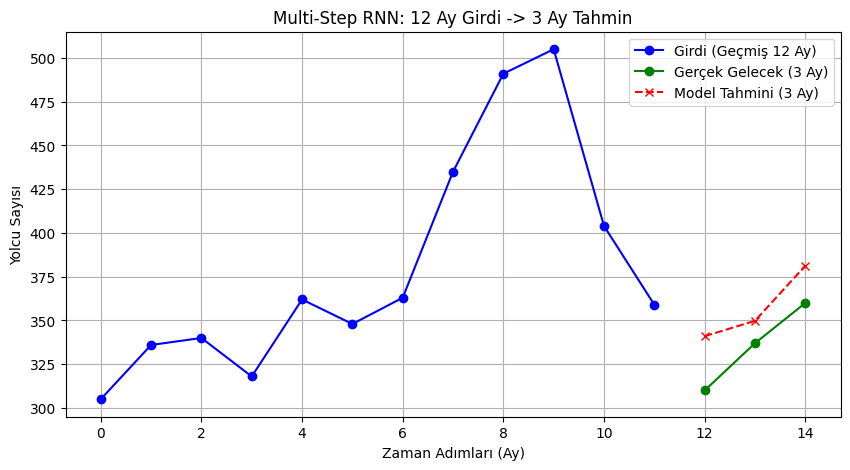

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# --- AYARLAR (Parametrik Yapı) ---
input_window = 12   # Geçmiş 12 aya bak
output_window = 3   # Gelecek 3 ayı tahmin et
hidden_size = 64    # RNN nöron sayısı
epochs = 100

# 1. Veri Setini Yükleme
try:
    df = sns.load_dataset("flights")
    data = df['passengers'].values.astype(float)
except:
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
    df = pd.read_csv(url)
    data = df['Passengers'].values.astype(float)

# 2. Normalizasyon
scaler = MinMaxScaler(feature_range=(-1, 1)) # RNN için -1, 1 aralığı genelde daha iyidir
data_normalized = scaler.fit_transform(data.reshape(-1, 1))
data_normalized = torch.FloatTensor(data_normalized).view(-1)

# 3. Parametrik Kayan Pencere Fonksiyonu
def create_inout_sequences(input_data, tw, pw):
    """
    tw: train_window (input_window) - Girdi uzunluğu
    pw: prediction_window (output_window) - Çıktı uzunluğu
    """
    inout_seq = []
    L = len(input_data)
    # Döngü sınırına dikkat: Sondan pw kadar veri kalmalı ki etiket olabilsin
    for i in range(L - tw - pw + 1):
        # Girdi: i'den başla, tw kadar al
        train_seq = input_data[i : i + tw]
        
        # Hedef: Girdinin bittiği yerden başla, pw kadar al
        train_label = input_data[i + tw : i + tw + pw]
        
        inout_seq.append((train_seq, train_label))
    return inout_seq

# Veriyi hazırla
sequences = create_inout_sequences(data_normalized, input_window, output_window)

# Eğitim/Test Ayrımı (Son 24 ayı test için ayıralım)
test_size = 24
train_seqs = sequences[:-test_size]
test_seqs = sequences[-test_size:]

print(f"Toplam Örnek: {len(sequences)}")
print(f"Eğitim Örneği: {len(train_seqs)}")
print(f"Girdi Boyutu: {input_window} -> Çıktı Boyutu: {output_window}")

# 4. Model Mimarisi (Multi-Step Output)
class MultiStepRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size)
        
        # BURASI ÖNEMLİ: Çıkış katmanı artık output_window (3) kadar nörona sahip
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        # input_seq shape: (Seq_Len, Batch, Feature) -> (12, 1, 1)
        input_seq = input_seq.view(len(input_seq), 1, -1)
        
        rnn_out, _ = self.rnn(input_seq)
        
        # Son zaman adımının çıktısını alıyoruz ve Linear katmana sokuyoruz
        # Linear katman bize [output_window] boyutunda bir vektör veriyor
        predictions = self.linear(rnn_out.view(len(input_seq), -1))
        
        return predictions[-1] # Sadece son adımın tahmini (vektör olarak)

model = MultiStepRNN(input_size=1, hidden_size=hidden_size, output_size=output_window)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 5. Eğitim Döngüsü
print("Eğitim Başlıyor...")
for i in range(epochs):
    epoch_loss = 0
    for seq, labels in train_seqs:
        optimizer.zero_grad()
        
        y_pred = model(seq)
        
        # Etiketleri ve tahmini aynı şekle sokmak gerekebilir ama MSELoss genelde halleder
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        epoch_loss += single_loss.item()

    if i % 10 == 0:
        print(f'Epoch: {i:3} Loss: {epoch_loss / len(train_seqs):.6f}')

# 6. Test ve Görselleştirme
# Modelin ne kadar iyi olduğunu görmek için, test setinden rastgele bir örnek alıp tahmin ettirelim.
model.eval()

# Örnek: Test setindeki son pencereyi alıp geleceği tahmin edelim
# Bu gerçek verideki son 12 ayı alıp, veri setinde OLMAYAN veya sonrasındaki 3 ayı tahmin etmektir.
sample_input, sample_truth = test_seqs[0] # Test setinin başından bir örnek alalım

with torch.no_grad():
    prediction = model(sample_input)

# Geri dönüşüm (Inverse Transform)
# Boyutları (N, 1) şekline getiriyoruz scaler için
input_real = scaler.inverse_transform(sample_input.view(-1, 1).numpy())
truth_real = scaler.inverse_transform(sample_truth.view(-1, 1).numpy())
pred_real = scaler.inverse_transform(prediction.view(-1, 1).numpy())

# Grafik Çizimi
plt.figure(figsize=(10, 5))
plt.title(f"Multi-Step RNN: {input_window} Ay Girdi -> {output_window} Ay Tahmin")
plt.ylabel("Yolcu Sayısı")
plt.xlabel("Zaman Adımları (Ay)")

# X ekseni zaman çizelgesi oluşturma
x_input = np.arange(0, input_window)
x_output = np.arange(input_window, input_window + output_window)

# 1. Girdi Verisi (Mavi)
plt.plot(x_input, input_real, 'b-o', label='Girdi (Geçmiş 12 Ay)')

# 2. Gerçek Gelecek (Yeşil)
plt.plot(x_output, truth_real, 'g-o', label='Gerçek Gelecek (3 Ay)')

# 3. Tahmin Edilen Gelecek (Kırmızı)
plt.plot(x_output, pred_real, 'r--x', label='Model Tahmini (3 Ay)')

plt.legend()
plt.grid(True)
plt.show()

In [4]:
data

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [7]:
sequences = create_inout_sequences(data, input_window, output_window)
sequences[0]

(array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
        118.]),
 array([115., 126., 141.]))